In [32]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path
import pandas as pd
from krxns.network import construct_reaction_network, SuperMultiDiGraph
from hydra import compose, initialize
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.standardize import standardize_smiles
from IPython.display import SVG
import networkx as nx
from itertools import product
from functools import partial
from tqdm import tqdm

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose("filepaths")

def get_node_idx(smi, G):
    nidx = G.get_nodes_by_prop('smiles', smi)
    if len(nidx) == 0:
        return None
    else:
        return nidx[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
ccm_aa = pd.read_csv(Path(cfg.raw_data) / "ccm_aa.csv")
std_smi = partial(standardize_smiles, quiet=True, neutralization_mode="simple")

In [34]:
kcs = pd.read_csv(Path(cfg.interim_data) / "compounds.csv")
sources = pd.read_csv(Path(cfg.interim_data) / "default_sources.csv")
sources = sources['id'].tolist()
addtl_sources = kcs.loc[kcs["smiles"].apply(std_smi).isin(ccm_aa["smiles"]), "id"].tolist()
sources += addtl_sources
pnmc_lb = 0.33
rnmc_lb = 0.33

with open(Path(cfg.interim_data) / "mass_contributions.json", 'r') as f:
    mass_contributions = json.load(f)

edges, nodes = construct_reaction_network(
    mass_contributions=mass_contributions,
    compounds=kcs,
    sources=sources,
    pnmc_lb=pnmc_lb,
    rnmc_lb=rnmc_lb,
)


In [35]:
len(edges), len(nodes)

(14750, 6075)

In [36]:
G = SuperMultiDiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
shortest_paths = dict(G.shortest_path())

In [37]:
def show_path(source, target, topk = 1):
    node_path, edge_path = G.shortest_path(source, target)
    print(node_path)
    for i, step in enumerate(edge_path):
        print(f"STEP #{i+1}")
        for edge in step[:topk]:
            print([(k, v) for k, v in edge.items()])
            display(SVG(draw_reaction(edge["am_smarts"])))

In [38]:
def get_node_idx(smi, G):
    nidx = G.get_nodes_by_prop('smiles', smi)
    if len(nidx) == 0:
        return None
    else:
        return nidx[0]
_get_node_idx = partial(get_node_idx, G=G)

In [46]:
atom_threshold = 50
qty_cs = pd.read_parquet(Path(cfg.raw_data) / "qty_c_cpds.parquet")
qty_cs["nidx"] = qty_cs["smiles"].apply(_get_node_idx)
qty_cs = qty_cs[qty_cs["nidx"].notna()]
qty_cs['nidx'] = qty_cs['nidx'].astype(int)
qty_cs = qty_cs[qty_cs['n_atoms'] <= atom_threshold]
qty_cs.head()

,id,smiles,names,n_atoms,nidx
0,2324,CC(C)(C)C=O,"[2,2-dimethylpropanal]",6,1876
1,1975,CC(=O)C(C)(C)C,"[3,3-dimethylbutan-2-one]",7,1562
2,2323,CC(C)(C)C(O)C#N,"[(2S)-2-hydroxy-3,3-dimethylbutanenitrile]",8,1875
3,2322,CC(C)(C)C(C)(O)C#N,"[(2S)-2-hydroxy-2-methyl-3,3-dimethylbutanenit...",9,1874
4,3360,CC1(C)COC(=O)C1=O,[2-dehydropantolactone],9,2631


In [47]:
ccm_aa["nidx"] = ccm_aa["smiles"].apply(_get_node_idx)
ccm_aa = ccm_aa[ccm_aa["nidx"].notna()]
ccm_aa['nidx'] = ccm_aa['nidx'].astype(int)
ccm_aa.head()

,id,smiles,nidx
8,alanine,CC(N)C(=O)O,2513
10,asparagine,NC(=O)CC(N)C(=O)O,5398
11,aspartic_acid,NC(CC(=O)O)C(=O)O,5450
12,cysteine,NC(CS)C(=O)O,5527
13,glutamine,NC(=O)CCC(N)C(=O)O,5400


In [48]:
sts = list(product(ccm_aa["nidx"], qty_cs["nidx"]))

In [49]:
paths = []
for s, t in tqdm(sts, total=len(sts)):
    if s not in shortest_paths or t not in shortest_paths[s]:
        continue
    _path = shortest_paths[s][t]
    paths.append(
        {
            "source": s,
            "target": t,
            "path": _path,
            "path_length": len(_path) - 1,
            "source_smiles": ccm_aa.loc[ccm_aa['nidx'] == s, 'smiles'].values[0],
            "target_smiles": qty_cs.loc[qty_cs['nidx'] == t, 'smiles'].values[0],
            "source_name": ccm_aa.loc[ccm_aa['nidx'] == s, 'id'].values[0],
            "target_name": qty_cs.loc[qty_cs['nidx'] == t, 'names'].values[0][0],
        }
    )
paths = pd.DataFrame(paths)
paths.head()

100%|██████████| 10144/10144 [00:00<00:00, 382989.05it/s]


,source,target,path,path_length,source_smiles,target_smiles,source_name,target_name
0,5554,5456,"[5554, 5456]",1,NC(Cc1ccccc1)C(=O)O,NC(CC1(C(=O)O)C=CC(O)C=C1)C(=O)O,phenylalanine,L-arogenate
1,5554,5577,"[5554, 6057, 6043, 1318, 1317, 5577]",5,NC(Cc1ccccc1)C(=O)O,NC1C=CC(CC(=O)C(=O)O)(C(=O)O)C=C1,phenylalanine,4-amino-4-deoxyprephenate
2,5554,6043,"[5554, 6057, 6043]",2,NC(Cc1ccccc1)C(=O)O,O=C(O)C(=O)CC1(C(=O)O)C=CC(O)C=C1,phenylalanine,prephenate
3,5548,5456,"[5548, 5456]",1,NC(Cc1ccc(O)cc1)C(=O)O,NC(CC1(C(=O)O)C=CC(O)C=C1)C(=O)O,tyrosine,L-arogenate
4,5548,5577,"[5548, 6055, 6043, 1318, 1317, 5577]",5,NC(Cc1ccc(O)cc1)C(=O)O,NC1C=CC(CC(=O)C(=O)O)(C(=O)O)C=C1,tyrosine,4-amino-4-deoxyprephenate


In [50]:
paths.sort_values(by="path_length", ascending=True, inplace=True)
print(f"# quarternary carbon compounds reached form CCM: {len(paths["target"].unique())}")
paths.head(20)

# quarternary carbon compounds reached form CCM: 3


,source,target,path,path_length,source_smiles,target_smiles,source_name,target_name
0,5554,5456,"[5554, 5456]",1,NC(Cc1ccccc1)C(=O)O,NC(CC1(C(=O)O)C=CC(O)C=C1)C(=O)O,phenylalanine,L-arogenate
3,5548,5456,"[5548, 5456]",1,NC(Cc1ccc(O)cc1)C(=O)O,NC(CC1(C(=O)O)C=CC(O)C=C1)C(=O)O,tyrosine,L-arogenate
2,5554,6043,"[5554, 6057, 6043]",2,NC(Cc1ccccc1)C(=O)O,O=C(O)C(=O)CC1(C(=O)O)C=CC(O)C=C1,phenylalanine,prephenate
5,5548,6043,"[5548, 6055, 6043]",2,NC(Cc1ccc(O)cc1)C(=O)O,O=C(O)C(=O)CC1(C(=O)O)C=CC(O)C=C1,tyrosine,prephenate
1,5554,5577,"[5554, 6057, 6043, 1318, 1317, 5577]",5,NC(Cc1ccccc1)C(=O)O,NC1C=CC(CC(=O)C(=O)O)(C(=O)O)C=C1,phenylalanine,4-amino-4-deoxyprephenate
4,5548,5577,"[5548, 6055, 6043, 1318, 1317, 5577]",5,NC(Cc1ccc(O)cc1)C(=O)O,NC1C=CC(CC(=O)C(=O)O)(C(=O)O)C=C1,tyrosine,4-amino-4-deoxyprephenate


In [51]:
agg_map = {col: "first" for col in paths.columns if col != "target"}
agg_map = {
    "source": "first",
    "path": "first",
    "path_length": "min",
    "source_smiles": "first",
    "target_smiles": "first",
    "source_name": "first",
    "target_name": "first",
}
paths.groupby(["target"]).agg(agg_map).reset_index().sort_values(by="path_length", ascending=True).head(20)

,target,source,path,path_length,source_smiles,target_smiles,source_name,target_name
0,5456,5554,"[5554, 5456]",1,NC(Cc1ccccc1)C(=O)O,NC(CC1(C(=O)O)C=CC(O)C=C1)C(=O)O,phenylalanine,L-arogenate
2,6043,5554,"[5554, 6057, 6043]",2,NC(Cc1ccccc1)C(=O)O,O=C(O)C(=O)CC1(C(=O)O)C=CC(O)C=C1,phenylalanine,prephenate
1,5577,5554,"[5554, 6057, 6043, 1318, 1317, 5577]",5,NC(Cc1ccccc1)C(=O)O,NC1C=CC(CC(=O)C(=O)O)(C(=O)O)C=C1,phenylalanine,4-amino-4-deoxyprephenate


[5554, 6057, 6043]
STEP #1
[('reaction_id', 12145), ('pdt_normed_mass_frac', 0.9166666666666666), ('rct_normed_mass_frac', 0.9166666666666666), ('am_smarts', '[NH2:57][CH:45]([CH2:47][c:49]1[cH:52][cH:54][cH:56][cH:55][cH:53]1)[C:48](=[O:50])[OH:51].[NH2:8][C:7](=[O:9])[c:1]1[cH:6][cH:5][cH:4][n+:3]([CH:10]2[O:11][CH:13]([CH2:16][O:18][P:19](=[O:20])([OH:21])[O:22][P:23](=[O:24])([OH:25])[O:26][CH2:27][CH:28]3[O:29][CH:31]([n:34]4[cH:36][n:38][c:40]5[c:42]([NH2:44])[n:43][cH:41][n:39][c:37]54)[CH:32]([OH:35])[CH:30]3[OH:33])[CH:14]([OH:17])[CH:12]2[OH:15])[cH:2]1.[OH2:46]>>[NH2:8][C:7](=[O:9])[C:1]1=[CH:2][N:3]([CH:10]2[O:11][CH:13]([CH2:16][O:18][P:19](=[O:20])([OH:21])[O:22][P:23](=[O:24])([OH:25])[O:26][CH2:27][CH:28]3[O:29][CH:31]([n:34]4[cH:36][n:38][c:40]5[c:42]([NH2:44])[n:43][cH:41][n:39][c:37]54)[CH:32]([OH:35])[CH:30]3[OH:33])[CH:14]([OH:17])[CH:12]2[OH:15])[CH:4]=[CH:5][CH2:6]1.[O:50]=[C:48]([OH:51])[C:45](=[O:46])[CH2:47][c:49]1[cH:52][cH:54][cH:56][cH:55][cH:53]1.[NH3:57]'

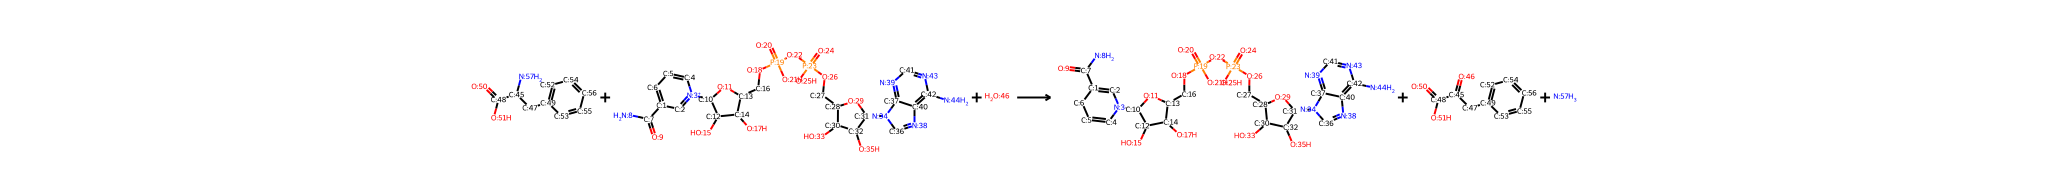

STEP #2
[('reaction_id', 6458), ('pdt_normed_mass_frac', 0.75), ('rct_normed_mass_frac', 1.0), ('am_smarts', '[O:3]=[C:2]=[O:10].[OH2:7].[O:15]=[C:13]([OH:16])[C:12](=[O:14])[CH2:11][c:1]1[cH:4][cH:5][cH:6][cH:8][cH:9]1>>[O:15]=[C:13]([OH:16])[C:12](=[O:14])[CH2:11][C:1]1([C:2](=[O:10])[OH:3])[CH:4]=[CH:5][CH:6]([OH:7])[CH:8]=[CH:9]1'), ('coreactants', {5946, 6453}), ('coproducts', set())]


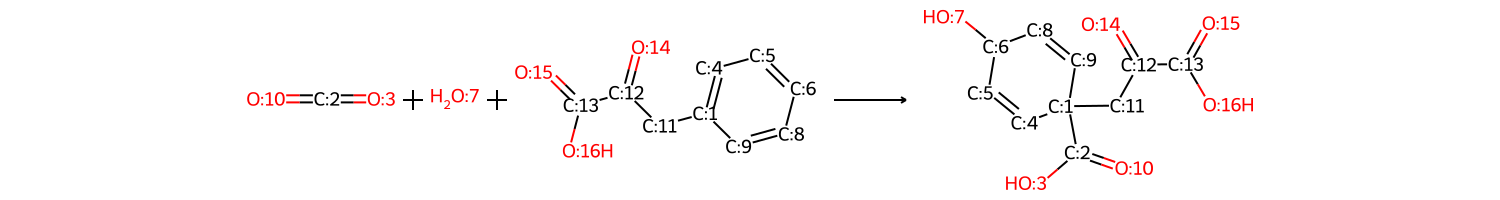

In [52]:
show_path(5554, 6043)